In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import sys
import numpy as np
sys.path.append(os.path.abspath("../PROTAC-Degradation-Predictor"))  
sys.path.append(os.path.join(os.getcwd(), '..', 'PROTAC-Degradation-Predictor'))
from matplotlib_venn import venn2
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import MolToSmiles
from sklearn.metrics import accuracy_score

import torch

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from protac_degradation_predictor import PROTAC_Model  

#import
import pandas as pd
import numpy as np
from typing import Optional

import warnings
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
from collections import defaultdict
from rdkit import DataStructs
from scipy.stats import spearmanr
import protac_degradation_predictor as pdp




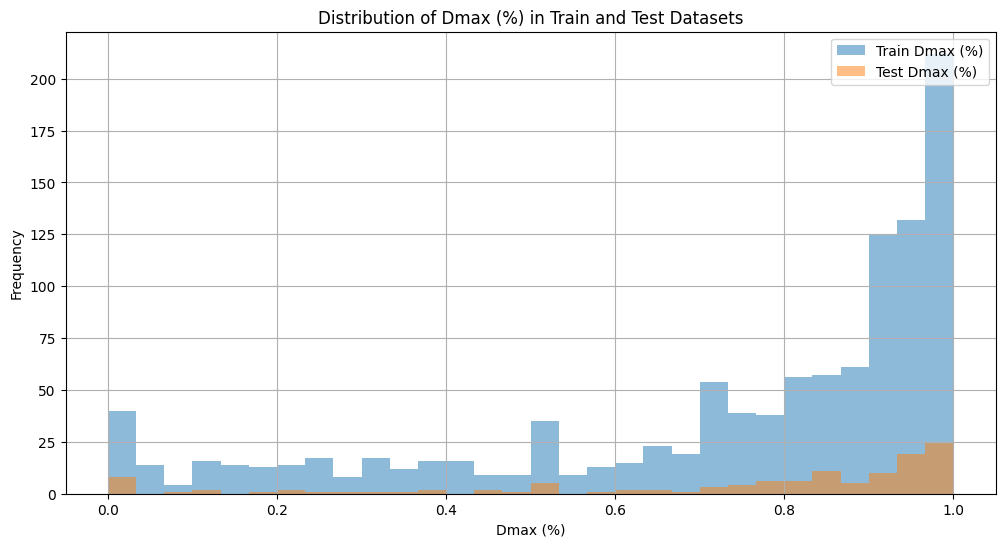

In [ ]:
# Dmax distribution in train and test set
train_df = pd.read_csv('../data/studies/Dmax_standard_train_0.9.csv')  
test_df = pd.read_csv('../data/studies/Dmax_standard_test_0.1.csv')

train_df['Dmax (%)'] = train_df['Dmax (%)'] / 100
test_df['Dmax (%)'] = test_df['Dmax (%)'] / 100

plt.figure(figsize=(12, 6))
plt.hist(train_df['Dmax (%)'], bins=30, alpha=0.5, label='Train Dmax (%)')
plt.hist(test_df['Dmax (%)'], bins=30, alpha=0.5, label='Test Dmax (%)')

plt.title('Distribution of Dmax (%) in Train and Test Datasets')
plt.xlabel('Dmax (%)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

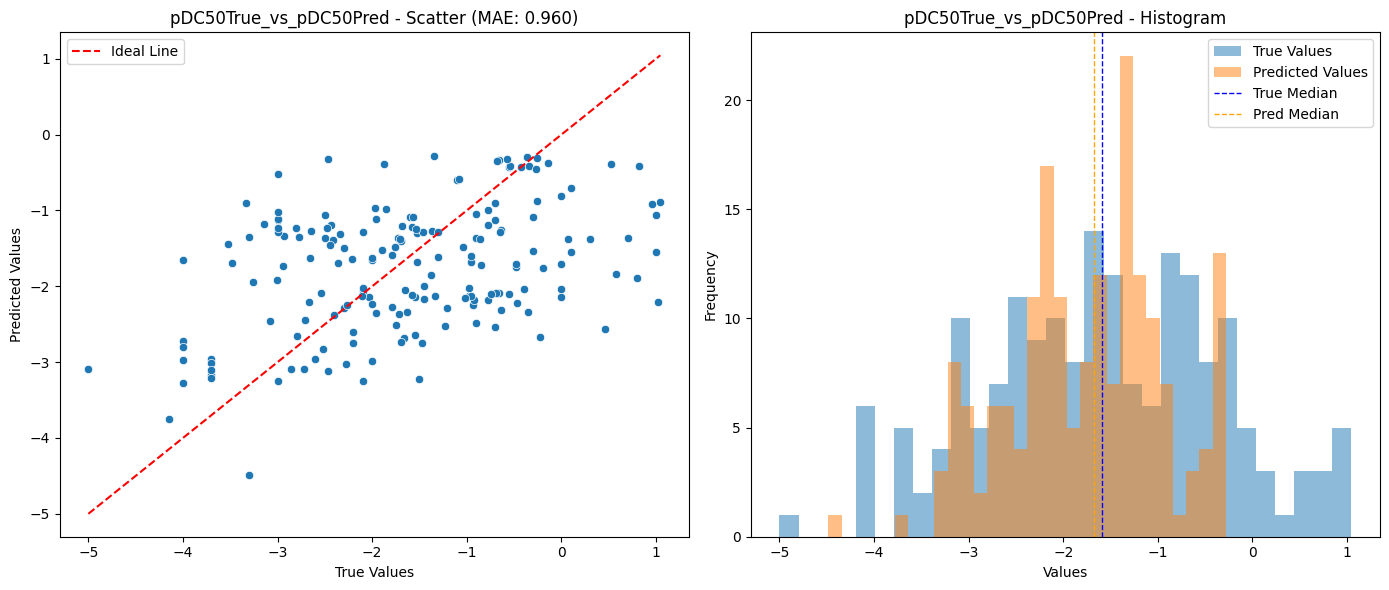

In [16]:
# y_pred and y_true were saved in a csv file after training
def plot_simple_pred_vs_true(csv_path, output_dir, plot_title, y_true_column='y_true', y_pred_column='y_pred'):
    # Read CSV with two columns: y_true and y_pred
    df = pd.read_csv(csv_path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=[y_true_column, y_pred_column], inplace=True)
    
    # Compute MAE
    mae = mean_absolute_error(df[y_true_column], df[y_pred_column])
    
    plt.figure(figsize=(14, 6))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true_column, y=y_pred_column, data=df)
    min_val = min(df[y_true_column].min(), df[y_pred_column].min())
    max_val = max(df[y_true_column].max(), df[y_pred_column].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Line')
    plt.title(f"{plot_title} - Scatter (MAE: {mae:.3f})")
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    
    # Histogram
    plt.subplot(1, 2, 2)
    plt.hist(df[y_true_column], bins=30, alpha=0.5, label='True Values')
    plt.hist(df[y_pred_column], bins=30, alpha=0.5, label='Predicted Values')
    
    # Median lines
    true_median = df[y_true_column].median()
    pred_median = df[y_pred_column].median()
    plt.axvline(true_median, color='blue', linestyle='dashed', linewidth=1, label='True Median')
    plt.axvline(pred_median, color='orange', linestyle='dashed', linewidth=1, label='Pred Median')
    
    plt.title(plot_title + " - Histogram")
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()  # Show in notebook cell
    
    # Optional: to save the plot, uncomment below
    # import os
    # output_path = os.path.join(output_dir, f"{plot_title.replace(' ', '_')}.png")
    # plt.savefig(output_path)
    # plt.close()

# Example usage
csv_path = '../logs/best_model_n1_pytorch_DC50_standard_regression_test_split_0.1_val_predictions.csv'
output_dir = '../plots'
plot_title = 'pDC50True_vs_pDC50Pred'

plot_simple_pred_vs_true(csv_path, output_dir, plot_title)

### test on share test set

### 3 models peformance on shared test

Loaded 1 models from ../logs/best_model_n1_pytorch_DC50_200_standard_regression_test_split_0.1/best_model_n1_pytorch_DC50_200_standard_regression_test_split_0.1/checkpoints
Number of models loaded: 1
Processing model: ../logs/best_model_n1_pytorch_DC50_200_standard_regression_test_split_0.1/best_model_n1_pytorch_DC50_200_standard_regression_test_split_0.1/checkpoints/best_model_n1_standard-epoch=10-val_acc=0.00-val_roc_auc=0.000.ckpt
Prediction shape for this model: torch.Size([225, 1])
Results for each study (Ensemble Model - standard):
        Study       MAE  Spearman Correlation  Sample Count
0      target  1.794869              0.120557            77
1  similarity  1.024560              0.332678            78
2      random  1.053877              0.623764            70

Overall MAE: 1.2973
Overall Spearman Correlation: 0.3360


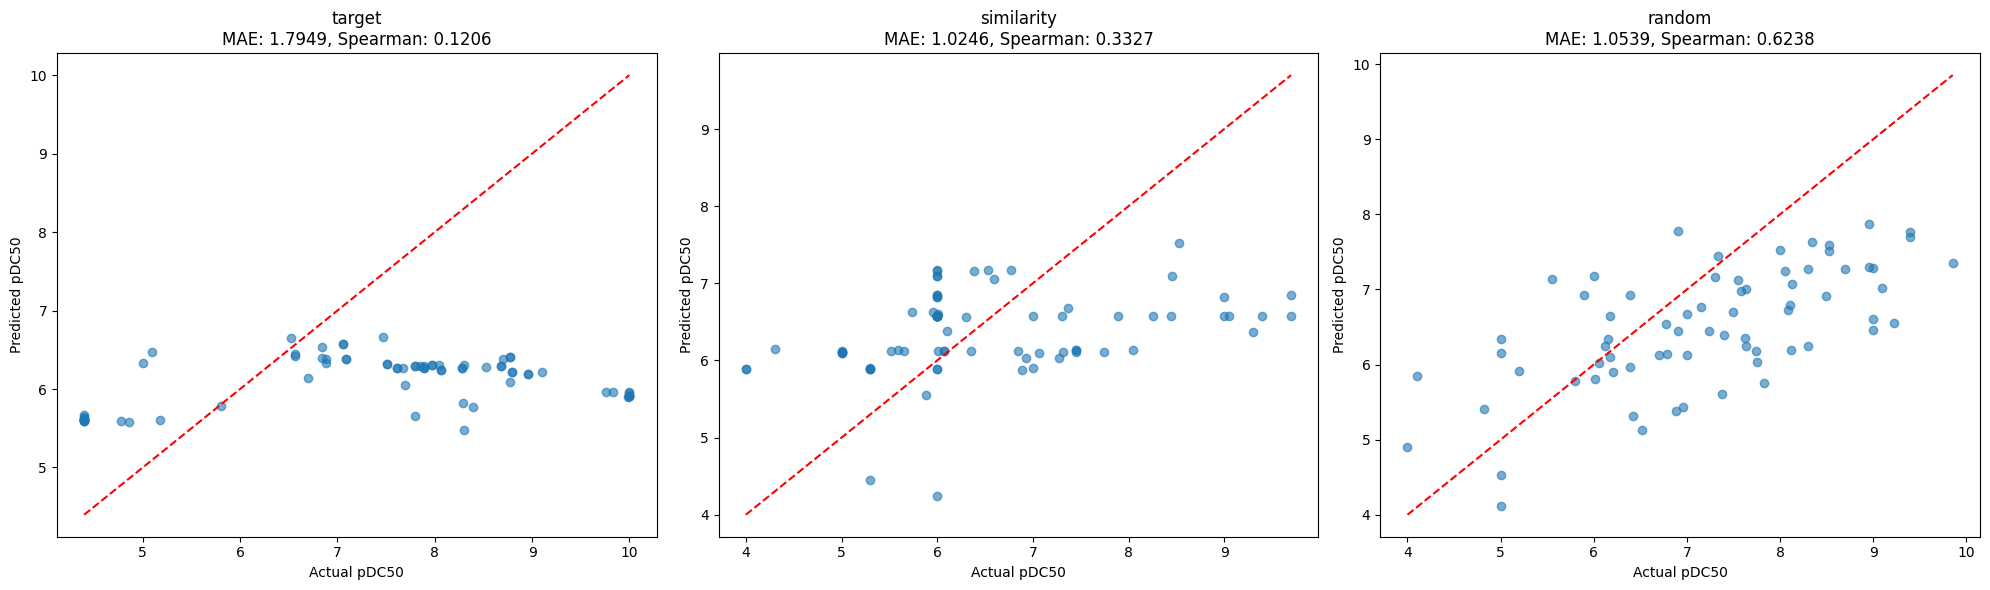

In [29]:
# Using mean of predictions from 3 best models as final prediction
# generize MAE matrix, scatter plots for one kind model performance on different subset of share test set

def safe_log10(x):
    """Safe log10 that handles zeros and negative numbers"""
    return np.log10(np.maximum(x, 1e-10))

def get_ensemble_predictions(model_dirs, df):
    all_predictions = []
    for model_dir in model_dirs:
        result = pdp.get_protac_active_regression_proba(
            protac_smiles=df['Smiles'].tolist(),
            e3_ligase=df['E3 Ligase'].tolist(),
            target_uniprot=df['Uniprot'].tolist(),
            cell_line=df['Cell Type'].tolist(),
            models_dir=model_dir
        )
        if 'mean' in result:
            all_predictions.append(result['mean'])
        else:
            print(f"Warning: No predictions available for model {model_dir}")
            return None
    # Average predictions from all models
    ensemble_predictions = np.mean(all_predictions, axis=0)
    return ensemble_predictions

def get_model_dirs(model_study, base_path='../logs'):
    ''' load model from'''
    return [
        f'{base_path}/best_model_n{i}_pytorch_DC50_200_{model_study}_regression_test_split_0.1/best_model_n{i}_pytorch_DC50_200_{model_study}_regression_test_split_0.1/checkpoints'
        for i in [1]
    ]

# Set model study type and data file
model_study = 'standard'
data_file = '../data/studies/DC50_share_test.csv'

# Load data
df = pd.read_csv(data_file)

################# Data preprocessing - DC50 ###############
df['DC50 (nM)'] = df['DC50 (nM)'].replace(0, np.nan)
df['pDC50'] = -safe_log10(df['DC50 (nM)'] * 1e-9)
df['pDC50'] = df['pDC50'].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=['pDC50'], inplace=True)

################## Data preprocessing - Dmax ###############
#df['Dmax (%)'] = df['Dmax (%)'] / 100


# Get model directories
model_dirs = get_model_dirs(model_study)

# Get ensemble model predictions
df['Predicted_pDC50'] = get_ensemble_predictions(model_dirs, df)

# Calculate MAE and Spearman correlation for each study
results = []
for study in df['study'].unique():
    study_df = df[df['study'] == study].dropna(subset=['pDC50', 'Predicted_pDC50'])
    if len(study_df) == 0:
        print(f"No valid data found for study: {study}")
        continue
    mae = mean_absolute_error(study_df['pDC50'], study_df['Predicted_pDC50'])
    spearman_corr, _ = spearmanr(study_df['pDC50'], study_df['Predicted_pDC50'])
    results.append({
        'Study': study,
        'MAE': mae,
        'Spearman Correlation': spearman_corr,
        'Sample Count': len(study_df)
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Calculate overall MAE and Spearman correlation
overall_mae = mean_absolute_error(df['pDC50'], df['Predicted_pDC50'])
overall_spearman, _ = spearmanr(df['pDC50'], df['Predicted_pDC50'])

# Print results
print(f"Results for each study (Ensemble Model - {model_study}):")
print(results_df)
print(f"\nOverall MAE: {overall_mae:.4f}")
print(f"Overall Spearman Correlation: {overall_spearman:.4f}")

# Scatter plots for each study
unique_studies = df['study'].unique()
n_studies = len(unique_studies)
n_cols = 3
n_rows = (n_studies - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
axes = axes.flatten()
for i, study in enumerate(unique_studies):
    study_df = df[df['study'] == study].dropna(subset=['pDC50', 'Predicted_pDC50'])
    ax = axes[i]
    ax.scatter(study_df['pDC50'], study_df['Predicted_pDC50'], alpha=0.6)
    ax.plot([study_df['pDC50'].min(), study_df['pDC50'].max()],  
            [study_df['pDC50'].min(), study_df['pDC50'].max()], 'r--')
    mae = results_df[results_df['Study'] == study]['MAE'].values[0]
    spearman = results_df[results_df['Study'] == study]['Spearman Correlation'].values[0]
    ax.set_title(f'{study}\nMAE: {mae:.4f}, Spearman: {spearman:.4f}')
    ax.set_xlabel('Actual pDC50')
    ax.set_ylabel('Predicted pDC50')

# Hide extra subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

### logit dmax, normalize Dmax - TODO

In [81]:
def preprocess_dmax(df, column_name='Dmax (%)'):
    """
    Preprocess Dmax data: filter, normalize, and apply logit transformation.

    Args:
        df : pandas.DataFrame
            DataFrame containing Dmax data.
        column_name : str
            The column to process (default: 'Dmax (%)').

    Returns:
        pandas.DataFrame
            DataFrame with processed values and logit-transformed column.
    """
    # 1. Remove rows where Dmax (%) > 100
    df = df[df[column_name] <= 100]

    # 2. Convert Dmax (%) from percent to 0-1 scale
    df[column_name] = df[column_name] / 100

    # 3. Handle edge cases for proportions exactly 0 or 1
    df[column_name] = df[column_name].apply(lambda x: 0.999 if x == 1 else (0.001 if x == 0 else x))

    # Apply logit transformation
    logit_column_name = column_name + '_logit'
    df[logit_column_name] = np.log(df[column_name] / (1 - df[column_name]))

    return df

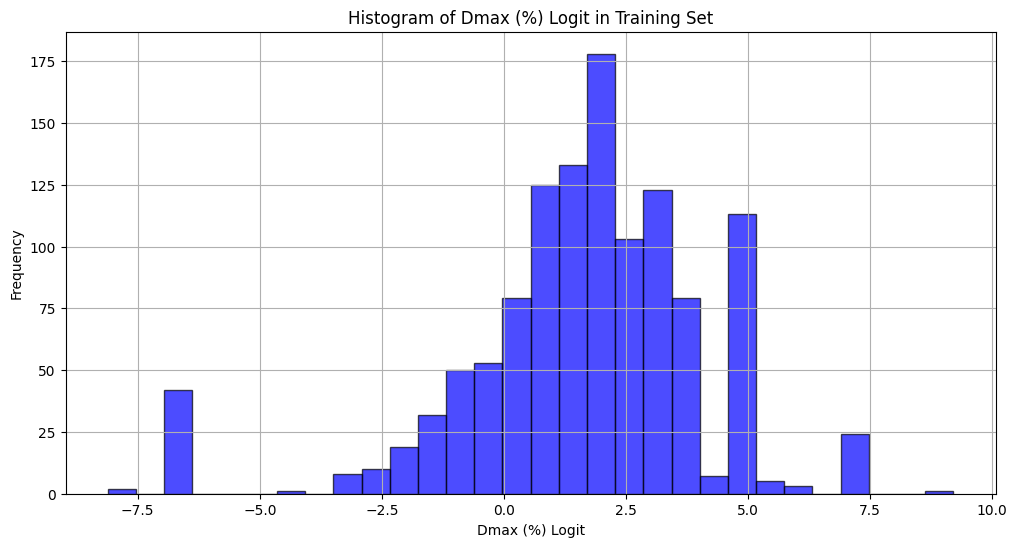

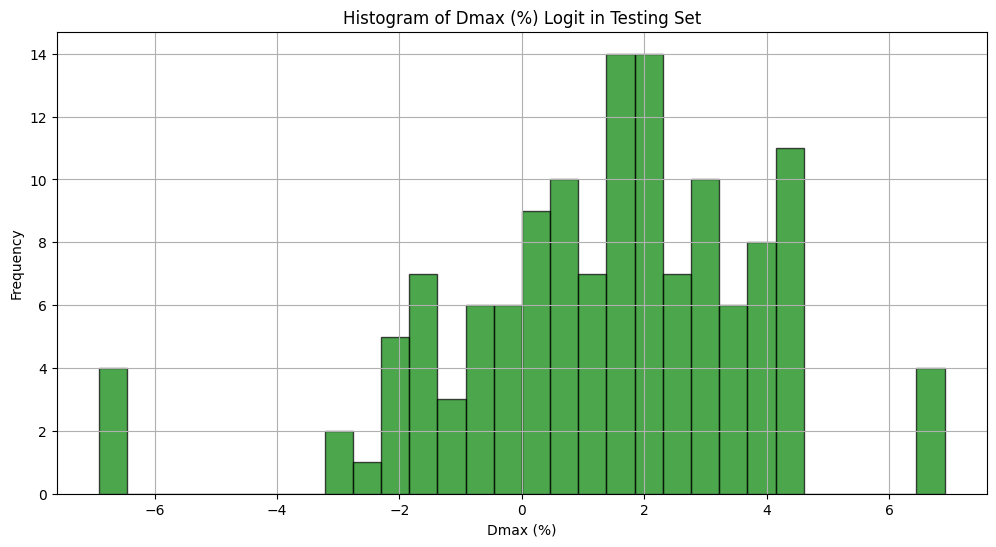

In [27]:
# Read data and apply preprocessing
train_val_filename = '../data/studies/Dmax_target_train_0.9.csv'
test_filename = '../data/studies/Dmax_target_test_0.1.csv'

train_val_df = pd.read_csv(train_val_filename)
test_df = pd.read_csv(test_filename)

train_val_df = preprocess_dmax(train_val_df, 'Dmax (%)')
test_df = preprocess_dmax(test_df, 'Dmax (%)')

# Plot histogram for Dmax_logit in the training set
plt.figure(figsize=(12, 6))
plt.hist(train_val_df['Dmax (%)_logit'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Dmax (%) Logit')
plt.ylabel('Frequency')
plt.title('Histogram of Dmax (%) Logit in Training Set')
plt.grid(True)
plt.show()

# Plot histogram for Dmax_logit in the testing set
plt.figure(figsize=(12, 6))
plt.hist(test_df['Dmax (%)_logit'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Dmax (%) Logit')
plt.ylabel('Frequency')
plt.title('Histogram of Dmax (%) Logit in Testing Set')
plt.grid(True)
plt.show()

### Classification test on share test

In [ ]:
# Majority vote  from 3 best models as final pred to calculate accuracy

def get_ensemble_predictions(model_dirs, df):
    all_predictions = []
    for model_dir in model_dirs:
        result = pdp.get_protac_active_proba(
            protac_smiles=df['Smiles'].tolist(),
            e3_ligase=df['E3 Ligase'].tolist(),
            target_uniprot=df['Uniprot'].tolist(),
            cell_line=df['Cell Type'].tolist(),
            models_dir=model_dir
        )
        all_predictions.append(result['majority_vote'])
    # Convert predictions to numpy array
    all_predictions = np.array(all_predictions)
    # Take majority vote across models for each sample
    ensemble_predictions = np.apply_along_axis(
        lambda x: np.bincount(x).argmax(),  
        axis=0,  
        arr=all_predictions
    )
    return ensemble_predictions

# Load data
df = pd.read_csv('../data/studies/Active_share_test.csv')

# Define model directories for the ensemble
model_dirs = [
    '../logs/best_model_n0_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/best_model_n0_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/checkpoints',
    '../logs/best_model_n1_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/best_model_n1_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/checkpoints',
    '../logs/best_model_n2_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/best_model_n2_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/checkpoints'
]

# Get ensemble predictions
df['Ensemble_Prediction'] = get_ensemble_predictions(model_dirs, df)

# Calculate accuracy for each study
results = []
for study in df['study'].unique():
    study_df = df[df['study'] == study]
    accuracy = accuracy_score(study_df['Active (Dmax 0.6, pDC50 6.0)'], study_df['Ensemble_Prediction'])
    results.append({
        'Study': study,
        'Accuracy': accuracy,
        'Sample Count': len(study_df)
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Sort by accuracy in descending order
results_df = results_df.sort_values('Accuracy', ascending=False)

# Calculate overall accuracy
overall_accuracy = accuracy_score(df['Active (Dmax 0.6, pDC50 6.0)'], df['Ensemble_Prediction'])

# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Print results
print("Accuracy by Study (Ensemble Model):")
print(results_df.to_string(index=False))
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.float_format')

Loaded 1 models from ../logs/best_model_n0_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/best_model_n0_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/checkpoints
Loaded 1 models from ../logs/best_model_n1_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/best_model_n1_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/checkpoints
Loaded 1 models from ../logs/best_model_n2_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/best_model_n2_pytorch_Active_standard_Active_Dmax_0.6_pDC50_6.0_test_split_0.1/checkpoints
Accuracy by Study (Ensemble Model):
     Study  Accuracy  Sample Count
similarity    0.8947            57
    random    0.8222            45
    target    0.7755            49

Overall Accuracy: 0.8344
